Step 1: Load the Data which is prepared from the nuscenes dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Load the Excel file
df = pd.read_excel('BoxAB_PCD_Association.xlsx')


In [3]:
print(df.columns.tolist())

['Unnamed: 0', 'a_scene_token', 'a_scene_name', 'a_sample_token', 'a_next_sample_token', 'a_instance_token', 'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 'a_box_translation_x', 'a_box_translation_y', 'a_box_translation_z', 'a_box_size_l', 'a_box_size_w', 'a_box_size_h', 'a_box_rotation_w', 'a_box_rotation_x', 'a_box_rotation_y', 'a_box_rotation_z', 'a_box_category_name', 'a_box_rad_translation_x', 'a_box_rad_translation_y', 'a_box_rad_translation_z', 'a_box_rad_rotation_w', 'a_box_rad_rotation_x', 'a_box_rad_rotation_y', 'a_box_rad_rotation_z', 'a_box_rad_size_l', 'a_box_rad_size_w', 'a_box_rad_size_h', 'a_radar_radar_token', 'a_radar_radar_x', 'a_radar_radar_y', 'a_radar_radar_z', 'a_radar_radar_trans_x', 'a_radar_radar_trans_y', 'a_radar_radar_trans_z', 'a_radar_dyn_prop', 'a_radar_cluster_id', 'a_radar_rcs', 'a_radar_vx', 'a_radar_vy', 'a_radar_vx_comp', 'a_radar_vy_comp', 'a_radar_is_quality_valid', 'a_radar_ambig_state', 'a_radar_x_rms', 'a_radar_y_rms', 'a_radar_inval

In [4]:
df_work = df.copy()
df_work = df_work[['a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 'a_box_translation_x', 'a_box_translation_y', 'a_box_translation_z', 
                        'a_box_size_l', 'a_box_size_w', 'a_box_size_h', 
                        'a_box_rotation_w', 'a_box_rotation_x', 'a_box_rotation_y', 'a_box_rotation_z', 
                        'a_box_category_name','a_radar_dyn_prop', 'a_radar_radar_distance', 
                        'a_can_brake', 'a_can_brake_switch', 'a_can_rear_left_rpm', 'a_can_rear_right_rpm', 'a_can_vehicle_speed', 'a_can_yaw_rate',
                        'b_camera_pose_x', 'b_camera_pose_y', 'b_camera_pose_z', 'b_box_translation_x', 'b_box_translation_y', 'b_box_translation_z', 
                        'b_box_size_l', 'b_box_size_w', 'b_box_size_h', 
                        'b_box_rotation_w', 'b_box_rotation_x', 'b_box_rotation_y', 'b_box_rotation_z', 
                        'b_box_category_name', 'b_radar_dyn_prop', 'b_radar_radar_distance', 
                        'b_can_brake', 'b_can_brake_switch', 'b_can_rear_left_rpm', 'b_can_rear_right_rpm', 'b_can_vehicle_speed', 'b_can_yaw_rate']]

In [5]:
dynprop_map = {
    0: 'Moving',
    1: 'Stationary',
    2: 'Oncoming',
    3: 'Stationary Candidate',
    4: 'Unknown',
    5: 'Crossing Stationary',
    6: 'Crossing Moving',
    7: 'Stopped'
}

df_work['a_dyn_label'] = df_work['a_radar_dyn_prop'].map(dynprop_map)

In [6]:
df_work.duplicated().sum()

np.int64(218)

In [7]:
df_work = df_work.drop_duplicates()
df_work.shape

(9264, 45)

In [8]:
df_work.groupby(['a_dyn_label', 'a_radar_dyn_prop'])[['a_radar_dyn_prop']].count()

a_radar_dyn_prop
a_dyn_label          a_radar_dyn_prop                  
Crossing Moving      6                              772
Crossing Stationary  5                              225
Moving               0                             1062
Oncoming             2                              422
Stationary           1                             6031
Stationary Candidate 3                              752

<Axes: title={'center': 'DynProp Distribution'}, xlabel='a_dyn_label'>

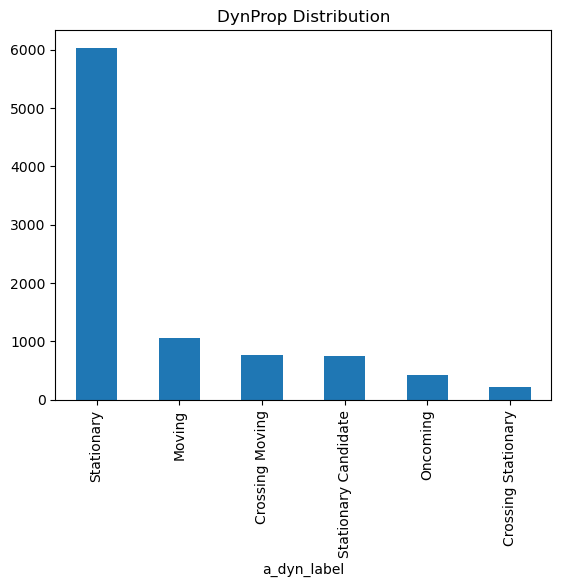

In [9]:
df_work['a_dyn_label'].value_counts().plot(kind='bar', title='DynProp Distribution')

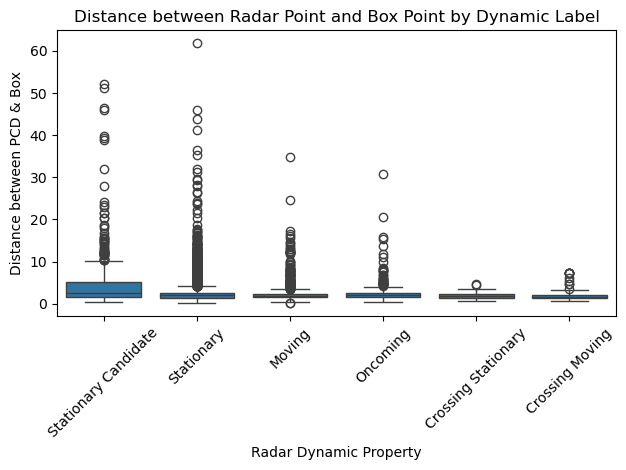

In [10]:
sns.boxplot(x='a_dyn_label', y='a_radar_radar_distance', data=df_work)
plt.xticks(rotation=45)  # Slants the labels
plt.xlabel('Radar Dynamic Property')
plt.ylabel('Distance between PCD & Box')

plt.title('Distance between Radar Point and Box Point by Dynamic Label')
plt.tight_layout()
plt.show()


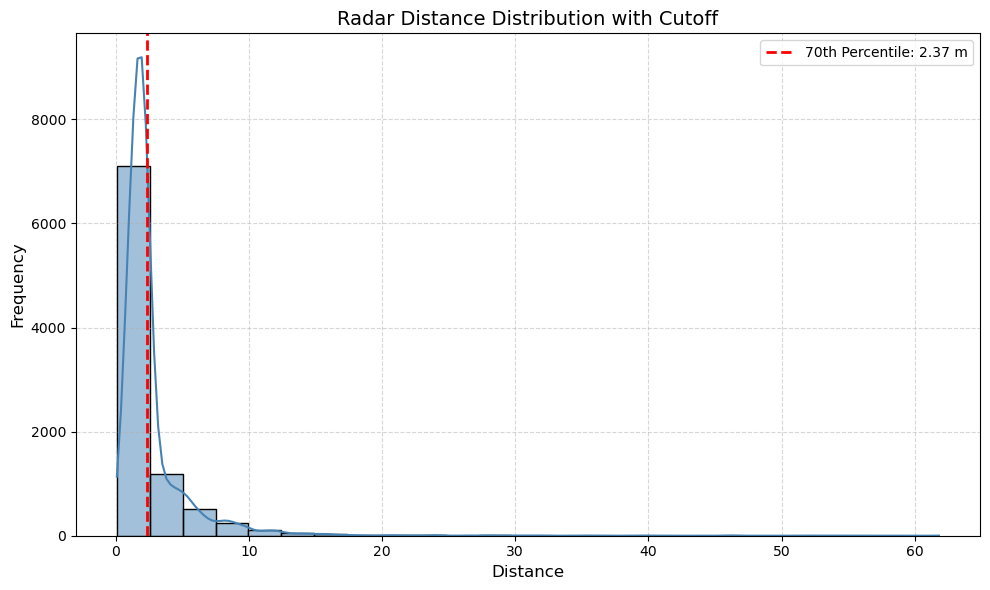

In [11]:

# Calculate the 85th percentile
cutoff_70 = np.percentile(df_work['a_radar_radar_distance'].dropna(), 70)

# Plot histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_work['a_radar_radar_distance'], bins=25, kde=True, color='steelblue')

# Add vertical line for 85th percentile
plt.axvline(cutoff_70, color='red', linestyle='--', linewidth=2, label=f'70th Percentile: {cutoff_70:.2f} m')

# Annotate and style
plt.title('Radar Distance Distribution with Cutoff', fontsize=14)
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.show()


In [12]:
# Drop NaNs to avoid issues
radar_distances = df_work['a_radar_radar_distance'].dropna()

# Define fixed cutoff
cutoff_distance = 2

# Count points below and above the cutoff
count_below = (radar_distances <= cutoff_distance).sum()
count_above = (radar_distances > cutoff_distance).sum()

print(f"Total points  : {count_below + count_above}")
print(f"Data points ≤ {cutoff_distance} meters: {count_below}")
print(f"Data points > {cutoff_distance} meters: {count_above}")


Total points  : 9264
Data points ≤ 2 meters: 4805
Data points > 2 meters: 4459


In [13]:
cutoff_distance = 2
df_below_cutoff = df_work[df_work['a_radar_radar_distance'] <= cutoff_distance]

In [14]:
df_below_cutoff.shape

(4805, 45)

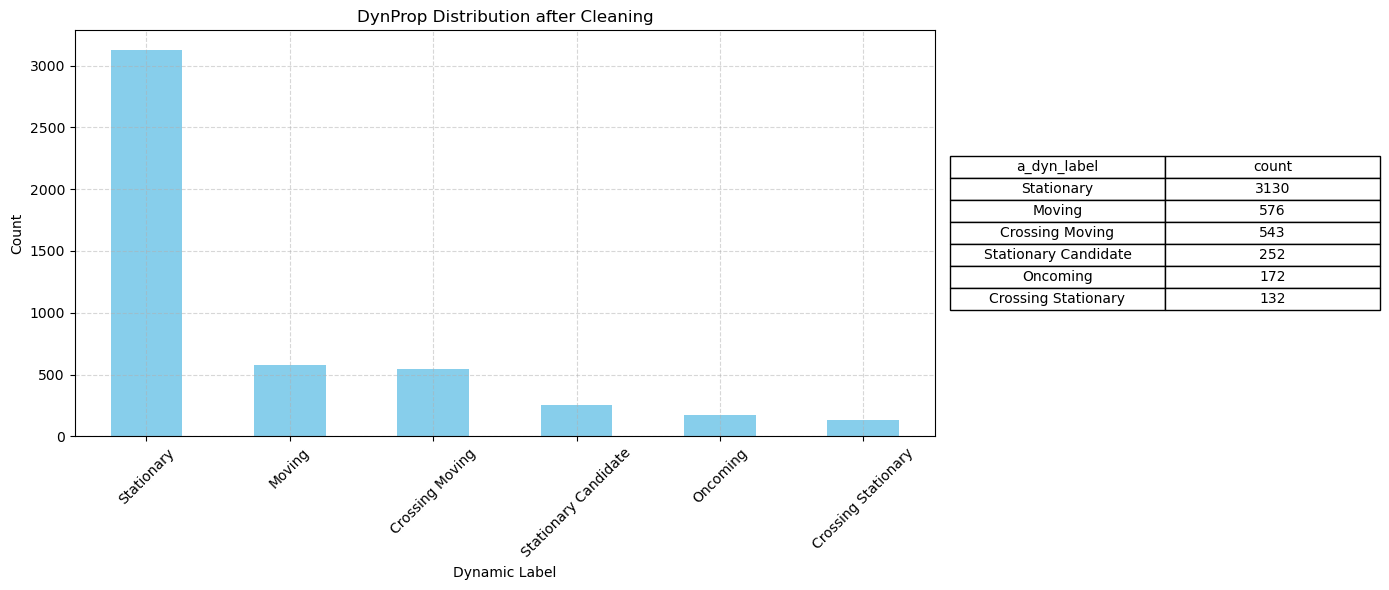

In [15]:
# Prepare data
dyn_counts = df_below_cutoff['a_dyn_label'].value_counts()

# Create figure with two subplots: bar chart (left), table (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

# Bar chart
dyn_counts.plot(kind='bar', ax=ax1, color='skyblue', title='DynProp Distribution after Cleaning')
ax1.set_xlabel('Dynamic Label')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', alpha=0.5)

# Data table
table_data = dyn_counts.reset_index()
table_data.columns = ['a_dyn_label', 'count']
ax2.axis('off')  # Hide axes
table = ax2.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='center')
table.scale(1, 1.5)  # Adjust size
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.tight_layout()
plt.show()


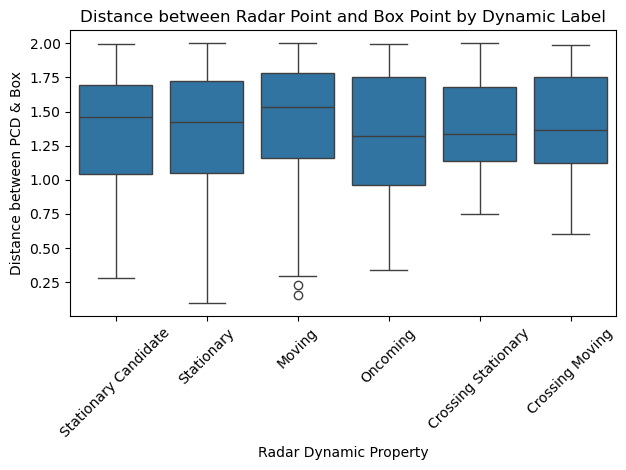

In [16]:
sns.boxplot(x='a_dyn_label', y='a_radar_radar_distance', data=df_below_cutoff)
plt.xticks(rotation=45)  # Slants the labels
plt.xlabel('Radar Dynamic Property')
plt.ylabel('Distance between PCD & Box')

plt.title('Distance between Radar Point and Box Point by Dynamic Label')
plt.tight_layout()
plt.show()


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Stationary Candidate'),
  Text(1, 0, 'Stationary'),
  Text(2, 0, 'Moving'),
  Text(3, 0, 'Oncoming'),
  Text(4, 0, 'Crossing Stationary'),
  Text(5, 0, 'Crossing Moving')])

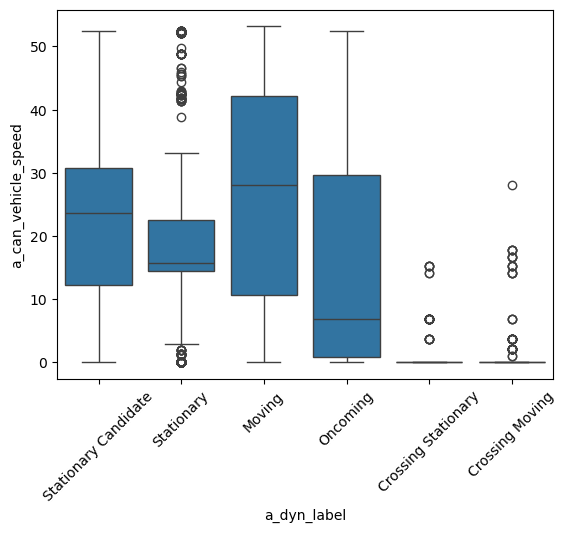

In [17]:
sns.boxplot(x='a_dyn_label', y='a_can_vehicle_speed', data=df_below_cutoff)
plt.xticks(rotation=45)  # Slants the labels

In [18]:
def plot_scatter_by_dyn_prop(df, hue_col, exclude_columns=None, fixed_axis='index', save=False):
    """
    Generates scatter plots for each column in the DataFrame with hue as 'dyn_prop'.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        exclude_columns (list): Columns to exclude from plotting.
        fixed_axis (str): Column to use as x-axis (default: 'index').
        save (bool): If True, saves plots as PNG files.
    """
    sns.set(style="whitegrid")
    exclude_columns = exclude_columns or [hue_col]

    for col in df.columns:
        if col not in exclude_columns:
            plt.figure(figsize=(8, 6))
            if fixed_axis == 'index':
                x_vals = df.index
            else:
                x_vals = df[fixed_axis]

            sns.scatterplot(x=x_vals, y=df[col], hue=df[hue_col], palette='viridis')
            plt.title(f'{col} vs {fixed_axis} (Hue: dyn_prop)')
            plt.xlabel(fixed_axis)
            plt.ylabel(col)
            plt.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()

            if save:
                plt.savefig(f'scatter_{col}_vs_{fixed_axis}.png')
            else:
                plt.show()

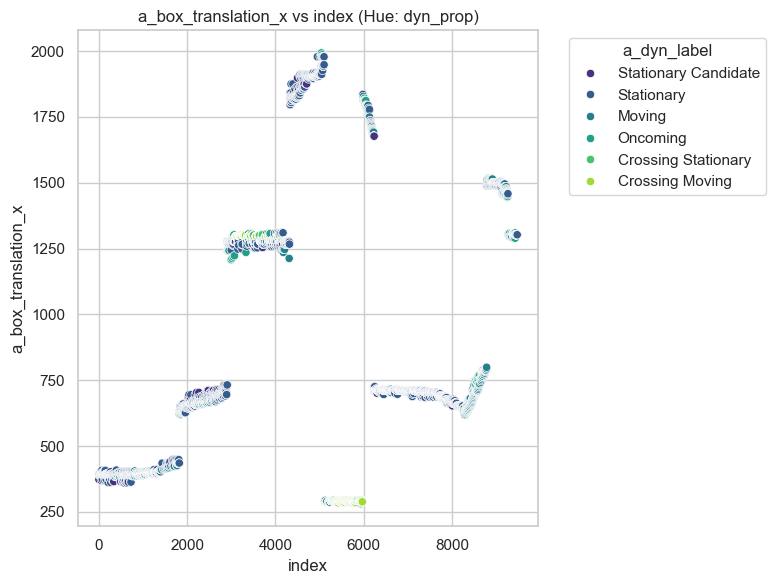

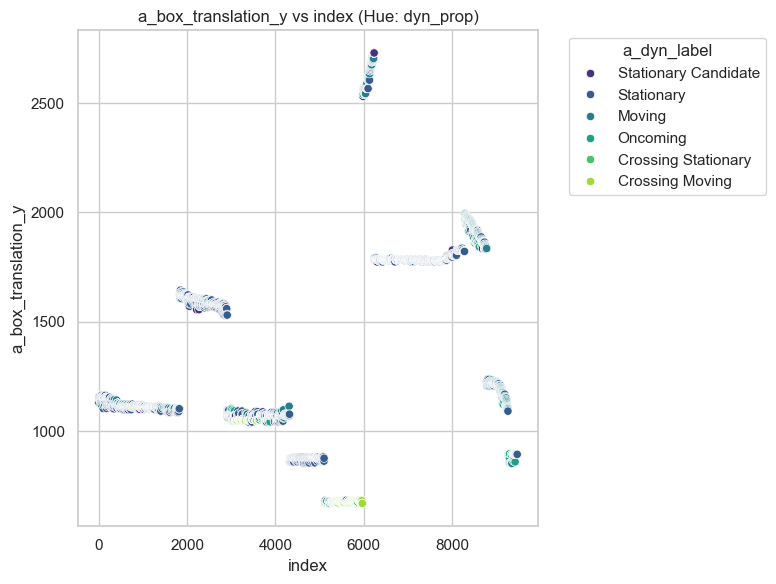

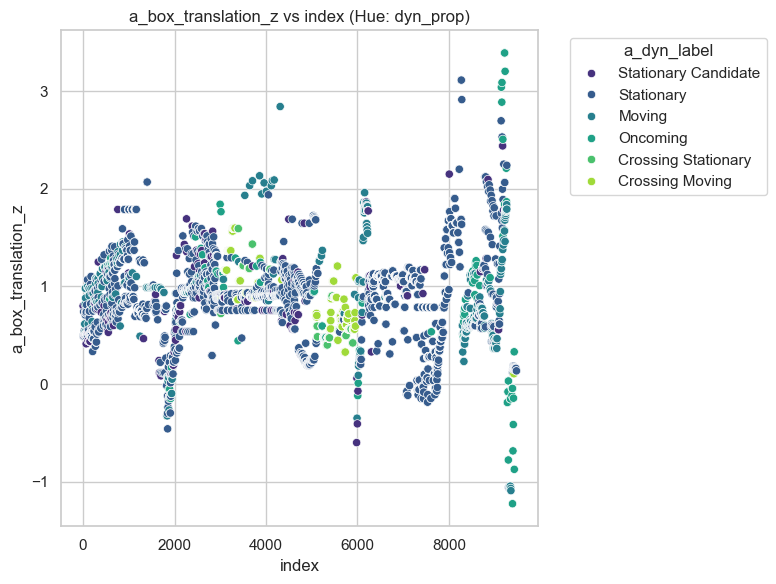

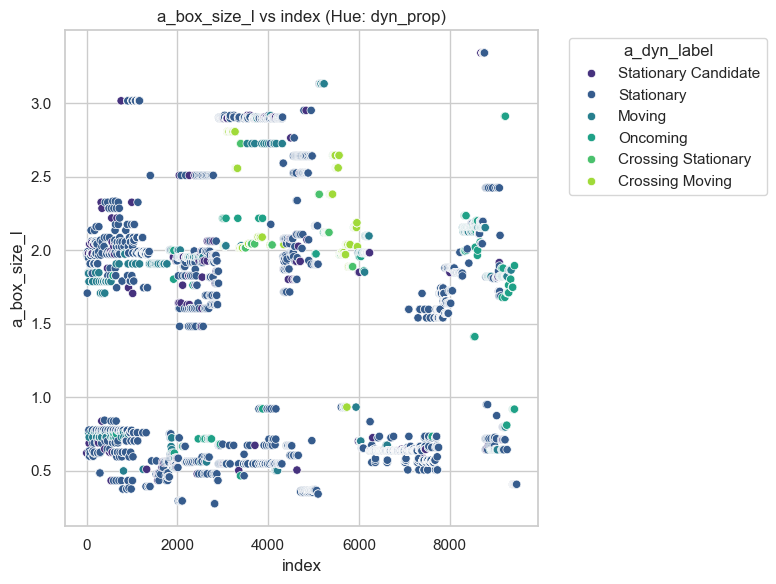

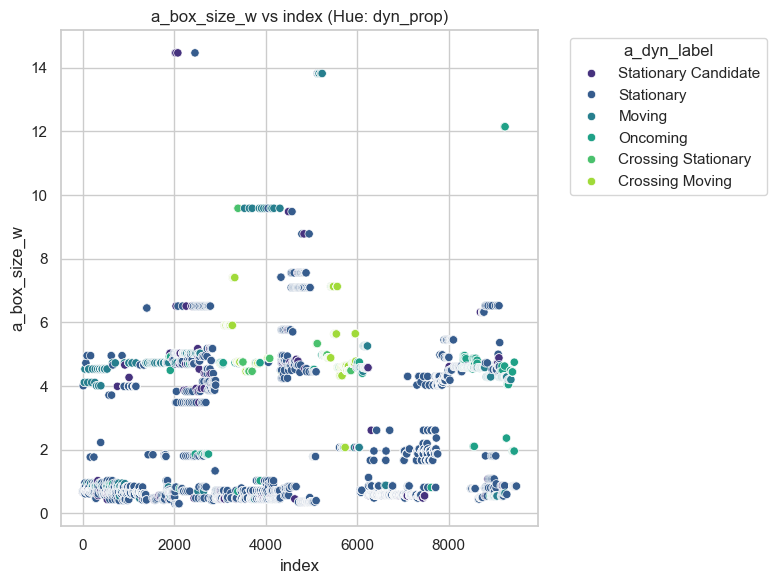

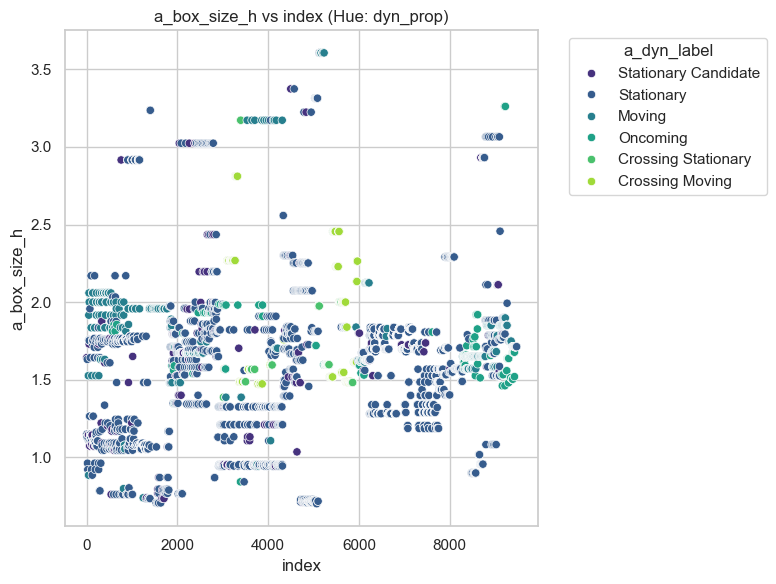

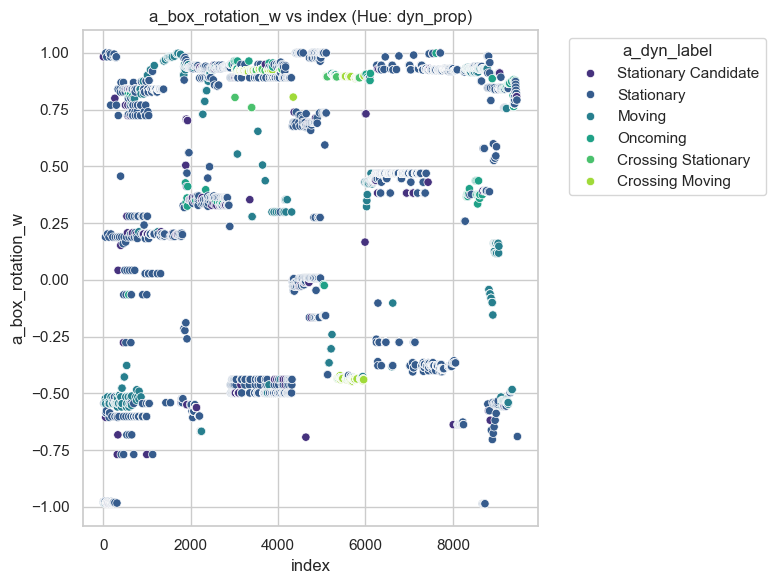

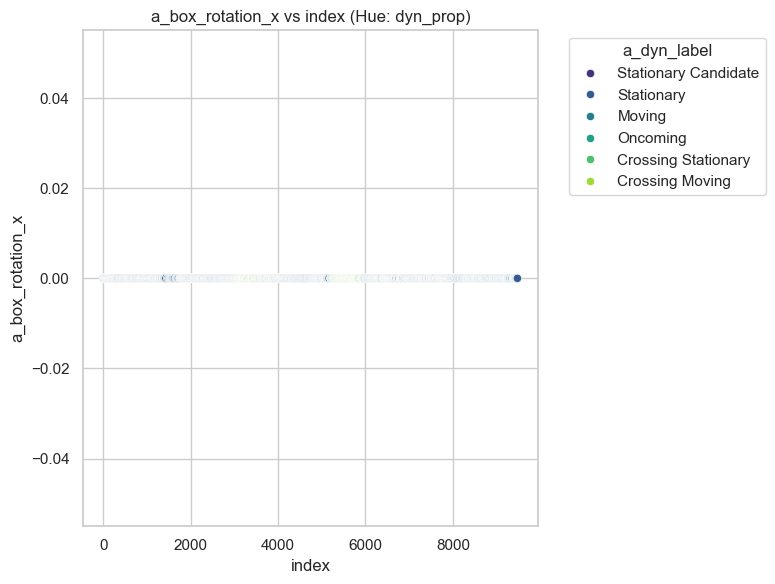

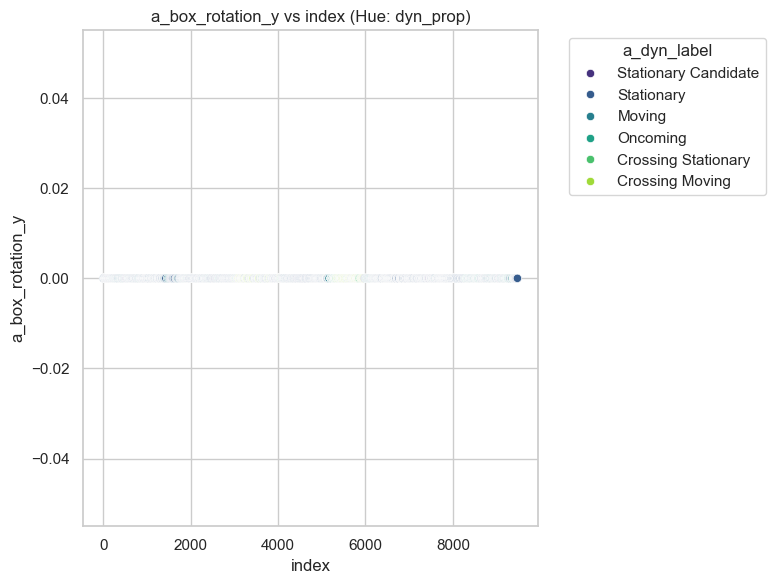

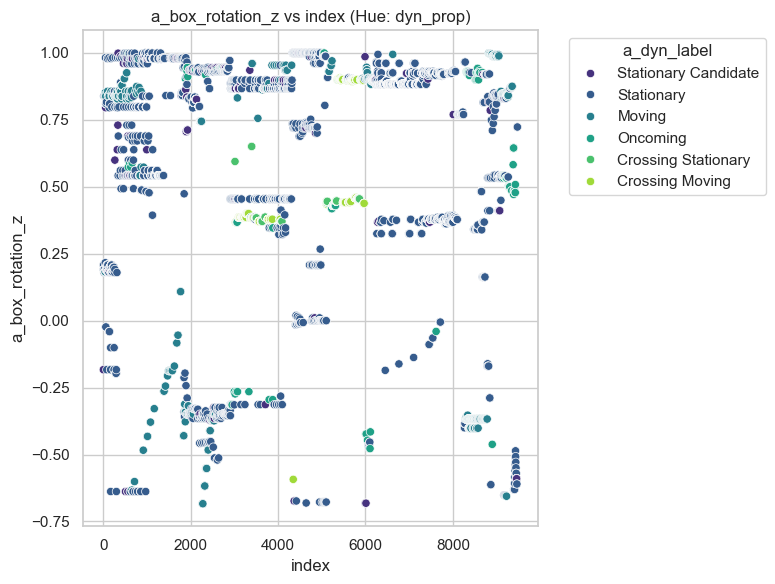

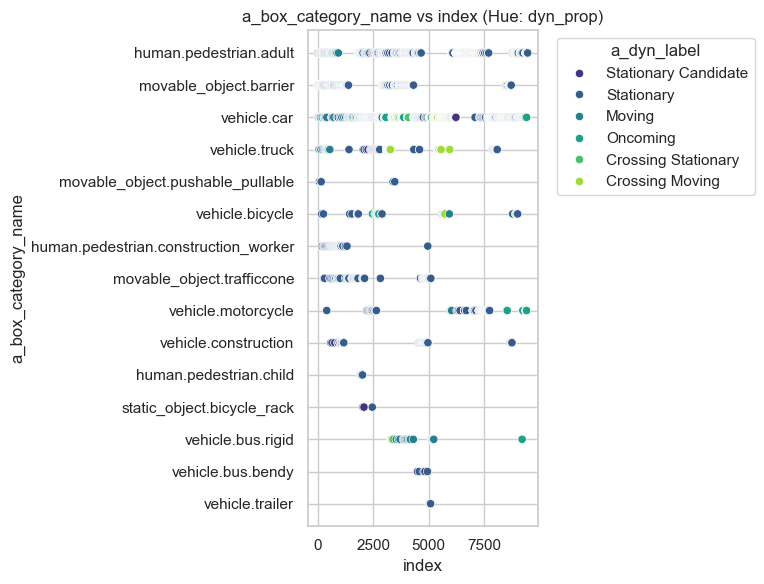

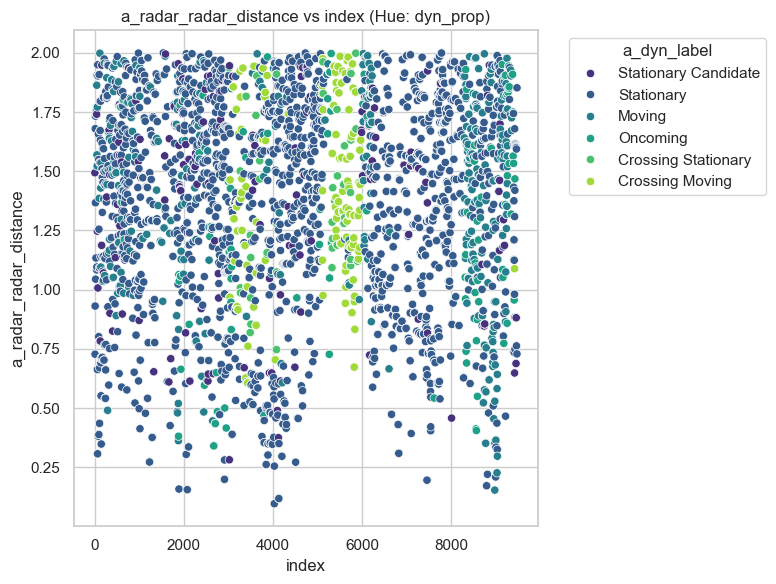

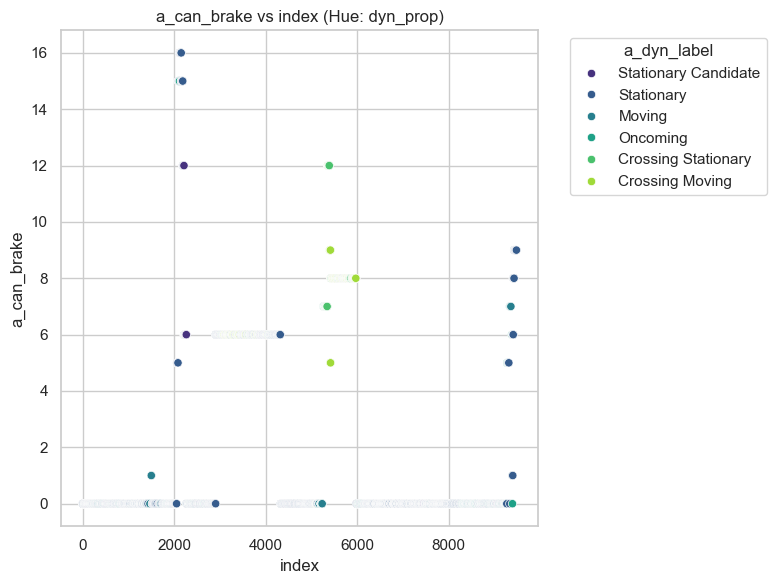

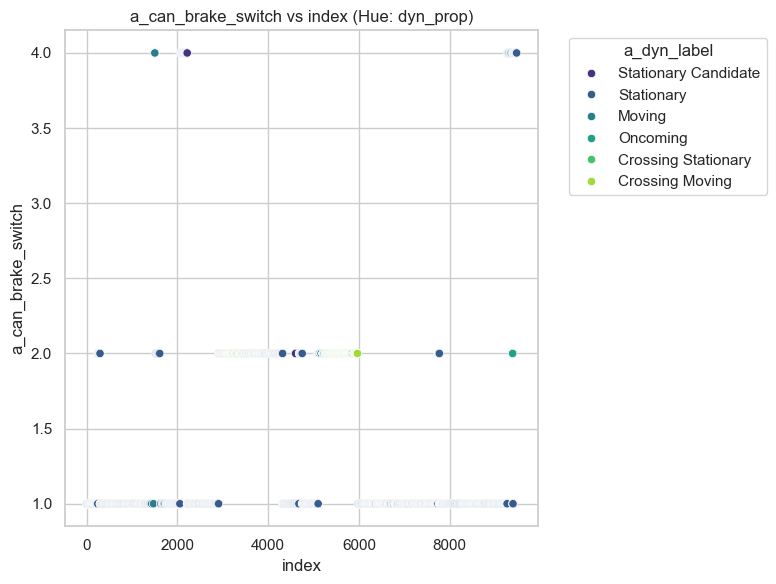

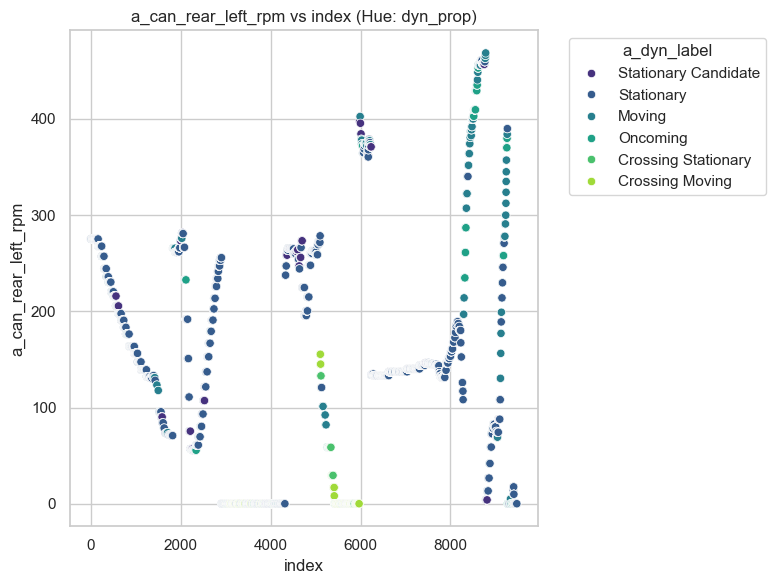

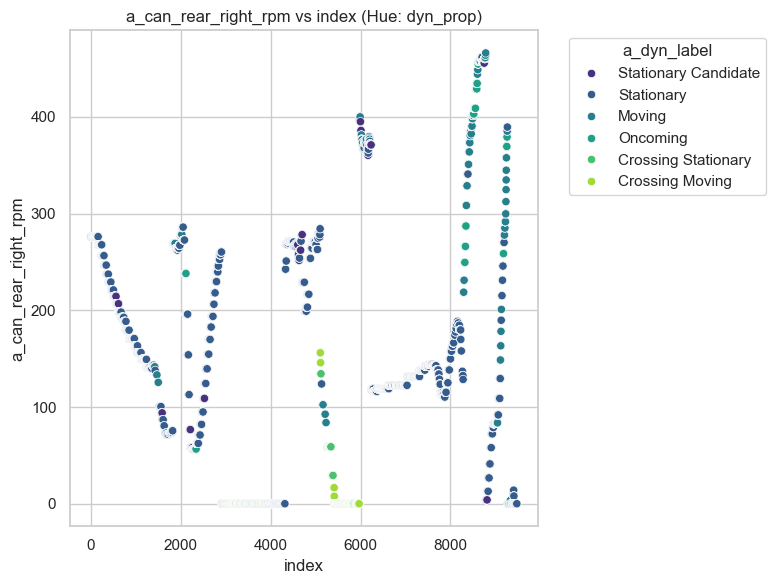

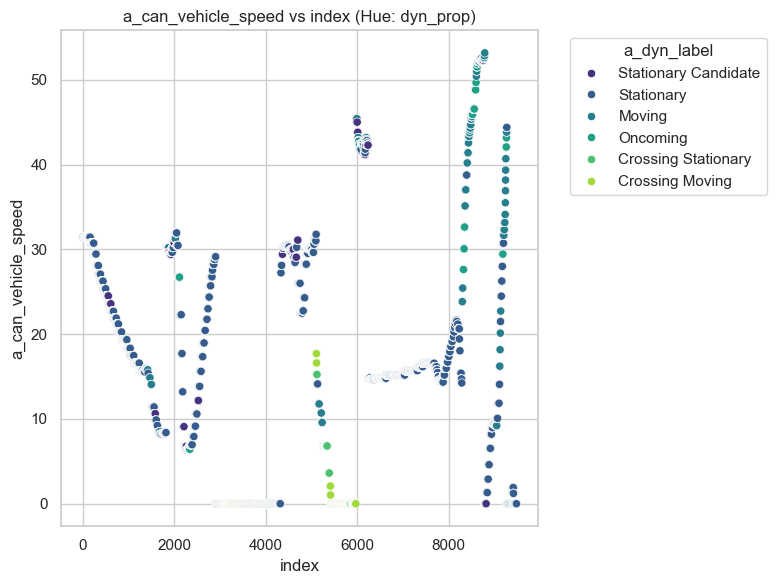

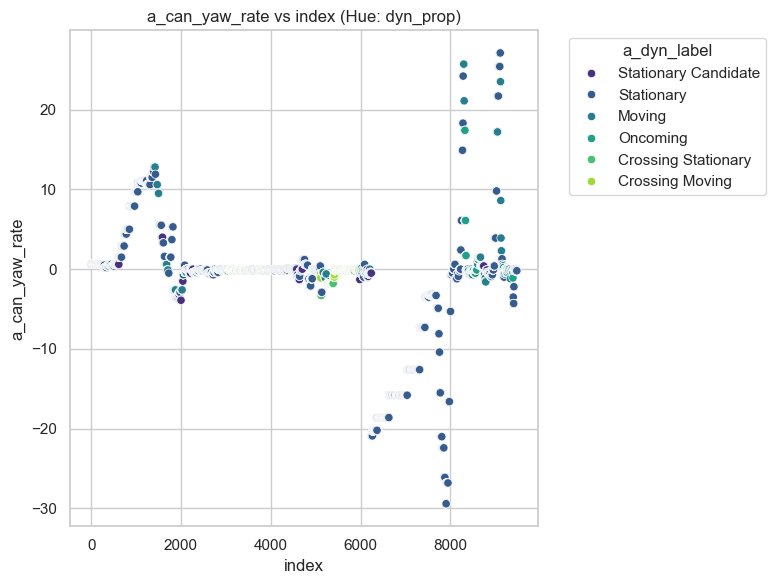

In [19]:
plot_scatter_by_dyn_prop(df_below_cutoff[['a_box_translation_x', 'a_box_translation_y', 'a_box_translation_z',
 'a_box_size_l', 'a_box_size_w', 'a_box_size_h',
 'a_box_rotation_w', 'a_box_rotation_x', 'a_box_rotation_y', 'a_box_rotation_z',
 'a_box_category_name',
 'a_radar_radar_distance',
 'a_can_brake',
 'a_can_brake_switch',
 'a_can_rear_left_rpm',
 'a_can_rear_right_rpm',
 'a_can_vehicle_speed',
 'a_can_yaw_rate',
 'a_dyn_label']], 'a_dyn_label')

Clear separation of data not seen. Need to further group data and check

In [20]:
def get_object_perspective(cam_pose_x, cam_pose_y, box_x, box_y, box_z, box_rotation_w, box_rotation_z):
    """
    Determines the perspective of an object relative to the camera.

    Parameters:
    - box_center: np.array([x, y, z]) → center of the box in world coordinates
    - orientation_quat: Quaternion(w, 0, 0, z) → rotation around Z-axis only
    - cam_position: np.array([x, y, z]) → camera position in world coordinates
    - threshold: angle threshold in radians for classification

    Returns:
    - One of: 'toward', 'away', 'left', 'right'
    """
    threshold=np.pi / 4

    # Camera position in global coordinates
    cam_position = np.array([cam_pose_x, cam_pose_y, 0])  # shape: (3,)

    orientation_quat = Quaternion(
        box_rotation_w,
        0.0, 0.0,
        box_rotation_z
    )
    
    # Compute forward direction of the box (local +X axis rotated by orientation)
    forward_vector = orientation_quat.rotate(np.array([1, 0, 0]))  # shape: (3,)

    # Vector from box to camera
    box_center = [box_x, box_y, box_z]
    to_camera = cam_position - box_center
    to_camera = to_camera / np.linalg.norm(to_camera)

    # Compute angle between forward direction and camera vector
    dot = np.dot(forward_vector[:2], to_camera[:2])  # only XY plane
    angle = np.arccos(np.clip(dot, -1.0, 1.0))  # radians

    # Pad vectors to 3D by adding a zero Z-component
    forward_xy = np.array([forward_vector[0], forward_vector[1], 0])
    to_camera_xy = np.array([to_camera[0], to_camera[1], 0])
    
    # Compute cross product and extract Z-component
    cross_z = np.cross(forward_xy, to_camera_xy)[2]


    # Classify based on angle and cross product
    if angle < threshold:
        return 0 #'toward'
    elif angle > (np.pi - threshold):
        return 1 #'away'
    elif cross_z > 0:
        return 2 #'left'
    else:
        return 3 #'right'

In [21]:
selected_columns = [
    'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 
    'b_camera_pose_x', 'b_camera_pose_y', 'b_camera_pose_z', 
    'a_box_translation_x', 'a_box_translation_y', 'a_box_translation_z', 
    'b_box_translation_x', 'b_box_translation_y', 'b_box_translation_z', 
    'a_box_size_l', 'a_box_size_w', 'a_box_size_h', 
    'b_box_size_l', 'b_box_size_w', 'b_box_size_h', 
    'a_box_rotation_w', 'a_box_rotation_x', 'a_box_rotation_y', 'a_box_rotation_z', 
    'b_box_rotation_w', 'b_box_rotation_x', 'b_box_rotation_y', 'b_box_rotation_z', 
    'a_box_category_name',
    'b_box_category_name', 
    'a_can_brake', 'a_can_brake_switch', 'a_can_rear_left_rpm', 'a_can_rear_right_rpm', 'a_can_vehicle_speed', 'a_can_yaw_rate',
    'b_can_brake', 'b_can_brake_switch', 'b_can_rear_left_rpm', 'b_can_rear_right_rpm', 'b_can_vehicle_speed', 'b_can_yaw_rate',
    'a_radar_radar_distance', 
    'b_radar_radar_distance', 
    'a_radar_dyn_prop',             
    'b_radar_dyn_prop']
    


df_below_cutoff = df_below_cutoff[selected_columns]

bins = [0, 3, 10, 20, 30, float('inf')]
labels = ['0', '3', '10', '20', '30']

# Create a new binned column
df_below_cutoff['a_can_vehicle_speed_bin'] = pd.cut(df_below_cutoff['a_can_vehicle_speed'], bins=bins, labels=labels, right=False)


# Encode box1_category_name
le_category = LabelEncoder()
df_below_cutoff['a_box_category_name_encoded'] = le_category.fit_transform(df_below_cutoff['a_box_category_name'])

def bin_yaw_rate(yaw):
    if yaw < -2.0:
        return -3; #'Sharp Left'
    elif -2.0 <= yaw < -1.0:
        return -2 #'Moderate Left'
    elif -1.0 <= yaw < -0.2:
        return -1 #'Gentle Left'
    elif -0.2 <= yaw <= 0.2:
        return 0 #'Straight'
    elif 0.2 < yaw <= 1.0:
        return 1 #'Gentle Right'
    elif 1.0 < yaw <= 2.0:
        return 2 #'Moderate Right'
    elif yaw > 2.0:
        return 3 #'Sharp Right'
    else:
        return 100 #'Unknown'

df_below_cutoff['a_can_yaw_rate_bin'] = df_below_cutoff['a_can_yaw_rate'].apply(bin_yaw_rate)
df_below_cutoff['b_can_yaw_rate_bin'] = df_below_cutoff['b_can_yaw_rate'].apply(bin_yaw_rate)

df_below_cutoff['a_box_perspective'] = df_below_cutoff.apply(
    lambda row: get_object_perspective(
        row['a_camera_pose_x'],
        row['a_camera_pose_y'],
        row['a_box_translation_x'],
        row['a_box_translation_y'],
        row['a_box_translation_z'],
        row['a_box_rotation_w'],
        row['a_box_rotation_z']
    ),
    axis=1
)

df_cleaned_data = df_below_cutoff.copy()

df_final_model_data = pd.DataFrame()

# Translation deltas
df_final_model_data['delta_translation_x'] = df_cleaned_data['b_box_translation_x'] - df_cleaned_data['a_box_translation_x']
df_final_model_data['delta_translation_y'] = df_cleaned_data['b_box_translation_y'] - df_cleaned_data['a_box_translation_y']
df_final_model_data['delta_translation_z'] = df_cleaned_data['b_box_translation_z'] - df_cleaned_data['a_box_translation_z']


def compute_delta_quaternion(row):
    q1 = Quaternion([row['a_box_rotation_w'], 0.0, 0.0, row['a_box_rotation_z']])
    q2 = Quaternion([row['b_box_rotation_w'], 0.0, 0.0, row['b_box_rotation_z']])
    delta_q = q2 * q1.inverse
    return pd.Series({'delta_rotation_w': delta_q.w, 'delta_rotation_x': delta_q.x, 'delta_rotation_y': delta_q.y,'delta_rotation_z': delta_q.z})

df_quat_delta = df_cleaned_data.apply(compute_delta_quaternion, axis=1)
df_final_model_data = pd.concat([df_final_model_data, df_quat_delta], axis=1)


df_final_model_data['a_box_size_l'] = df_cleaned_data['a_box_size_l']
df_final_model_data['a_box_size_w'] = df_cleaned_data['a_box_size_w']
df_final_model_data['a_box_size_h'] = df_cleaned_data['a_box_size_h']

df_final_model_data['a_box_tot'] = df_cleaned_data['a_box_size_l']+df_cleaned_data['a_box_size_w']+df_cleaned_data['a_box_size_h']

# Vehicle speed delta
df_final_model_data['a_can_vehicle_speed_bin'] = df_cleaned_data['a_can_vehicle_speed_bin']
df_final_model_data['delta_vehicle_speed'] = df_cleaned_data['b_can_vehicle_speed'] - df_cleaned_data['a_can_vehicle_speed']

# Vehicle brake state
df_final_model_data['a_can_brake'] = df_cleaned_data['a_can_brake']
df_final_model_data['b_can_brake'] = df_cleaned_data['b_can_brake']

# Directly copied columns
df_final_model_data['a_box_category_name_encoded'] = df_cleaned_data['a_box_category_name_encoded']
df_final_model_data['a_radar_dyn_prop'] = df_cleaned_data['a_radar_dyn_prop']
df_final_model_data['b_radar_dyn_prop'] = df_cleaned_data['b_radar_dyn_prop']
df_final_model_data['a_can_yaw_rate_bin'] = df_cleaned_data['a_can_yaw_rate_bin']
df_final_model_data['b_can_yaw_rate_bin'] = df_cleaned_data['b_can_yaw_rate_bin']


df_final_model_data['a_box_category_name_encoded'] = df_final_model_data['a_box_category_name_encoded'].astype('category')
df_final_model_data['a_can_vehicle_speed_bin'] = df_final_model_data['a_can_vehicle_speed_bin'].astype('category')
df_final_model_data['a_radar_dyn_prop'] = df_final_model_data['a_radar_dyn_prop'].astype('category')
df_final_model_data['b_radar_dyn_prop'] = df_final_model_data['b_radar_dyn_prop'].astype('category')
df_final_model_data['a_can_yaw_rate_bin'] = df_final_model_data['a_can_yaw_rate_bin'].astype('category')
df_final_model_data['b_can_yaw_rate_bin'] = df_final_model_data['b_can_yaw_rate_bin'].astype('category')
df_final_model_data['a_can_brake'] = df_final_model_data['a_can_brake'].astype('category')
df_final_model_data['b_can_brake'] = df_final_model_data['b_can_brake'].astype('category')


df_final_model_data = df_final_model_data.drop_duplicates()

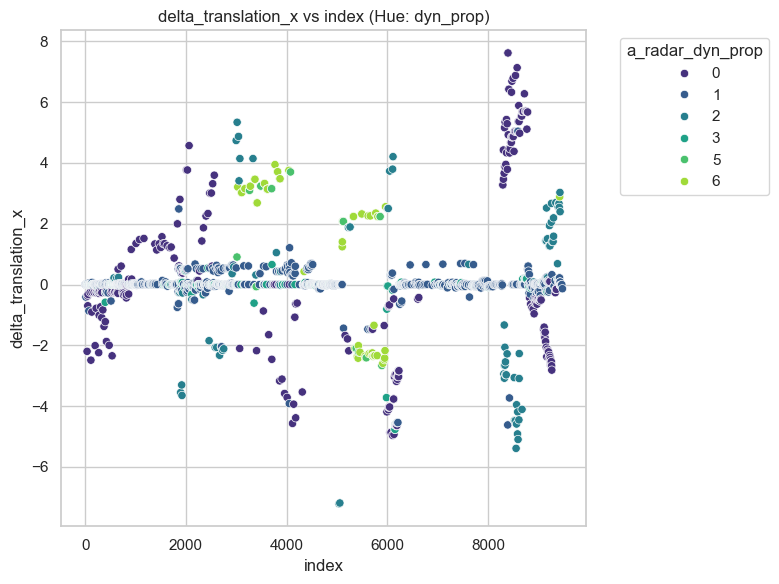

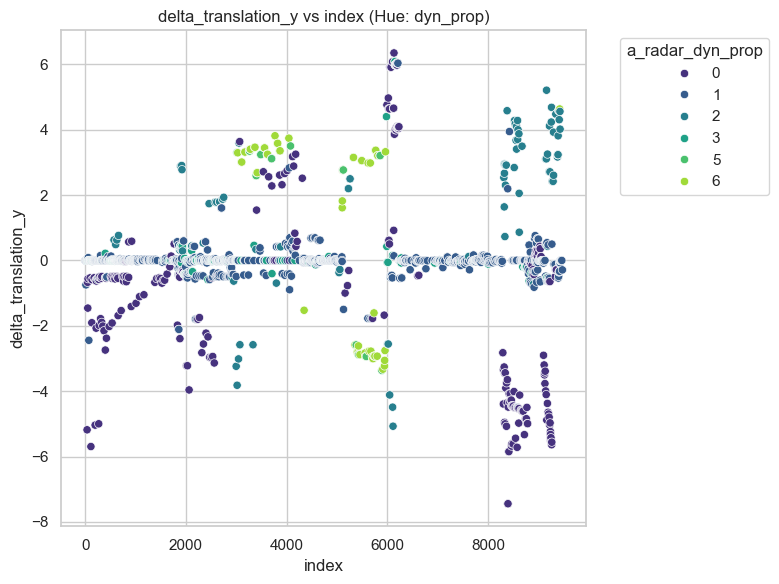

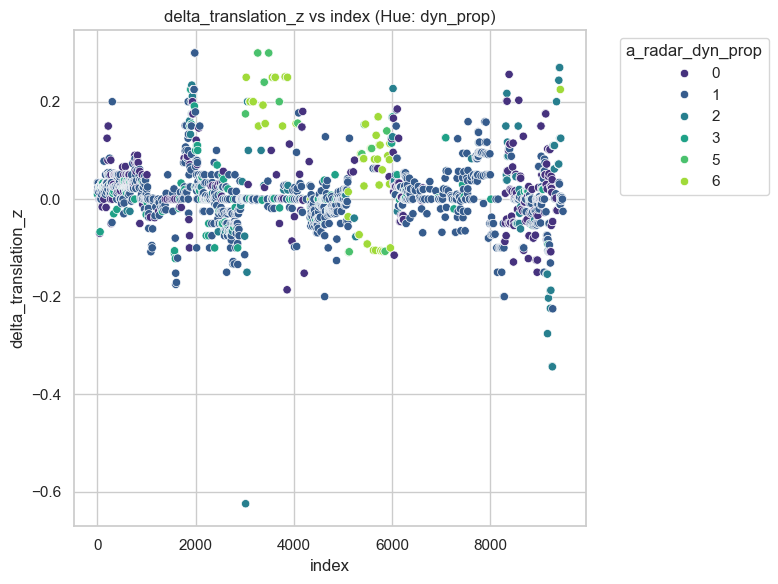

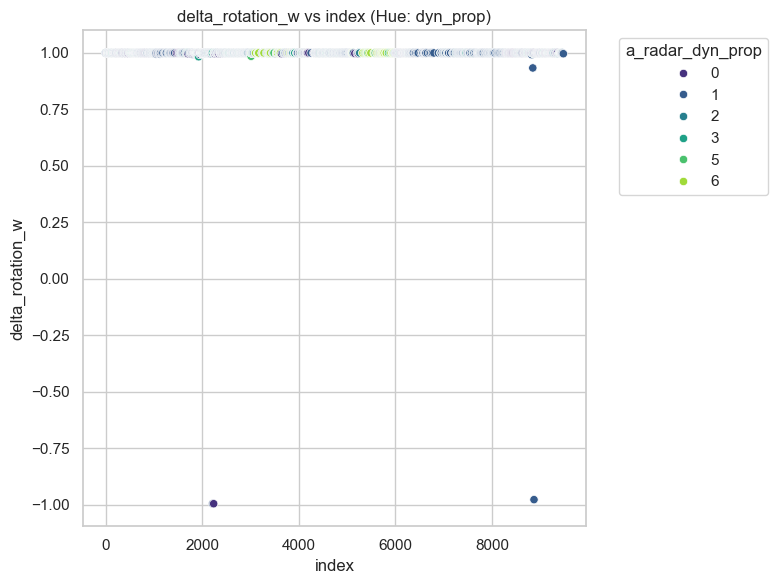

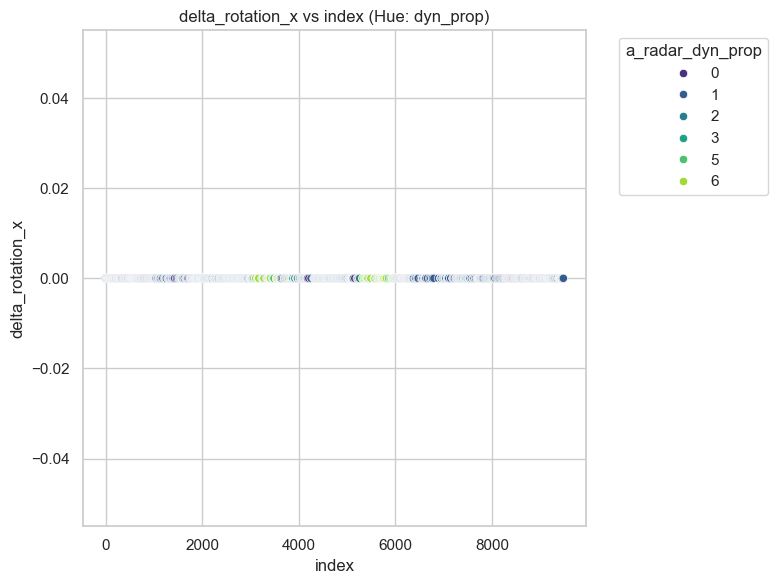

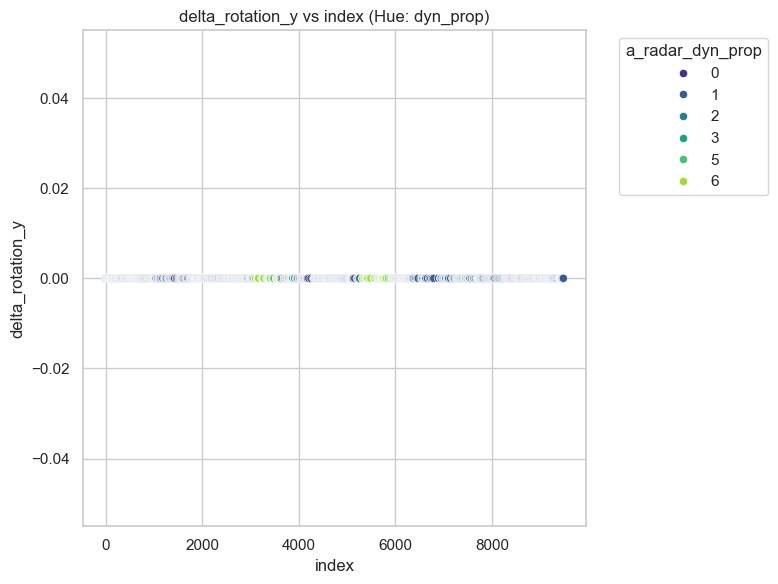

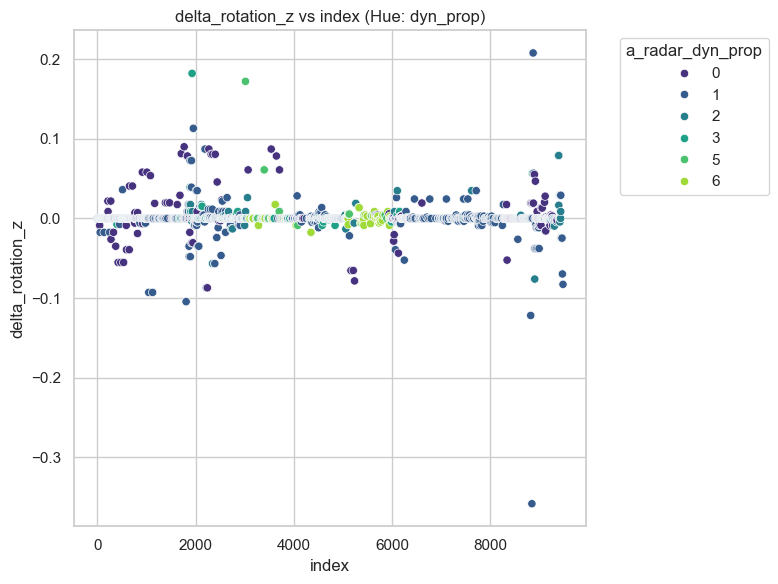

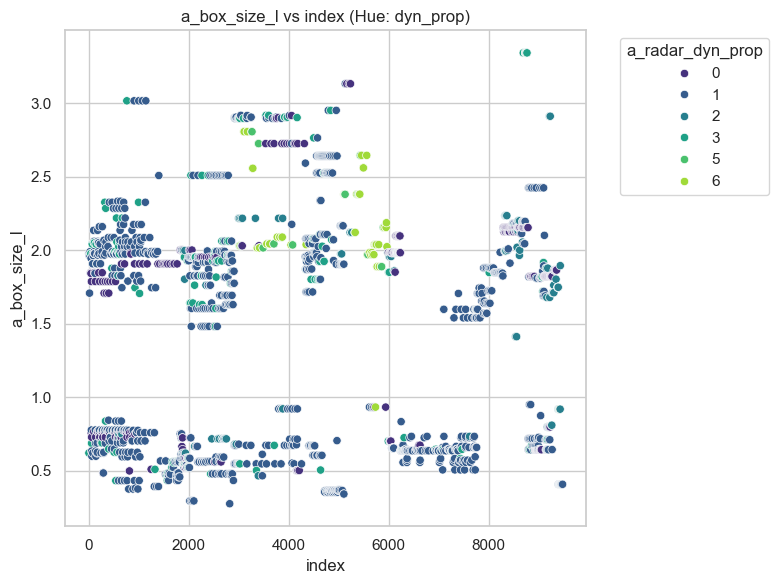

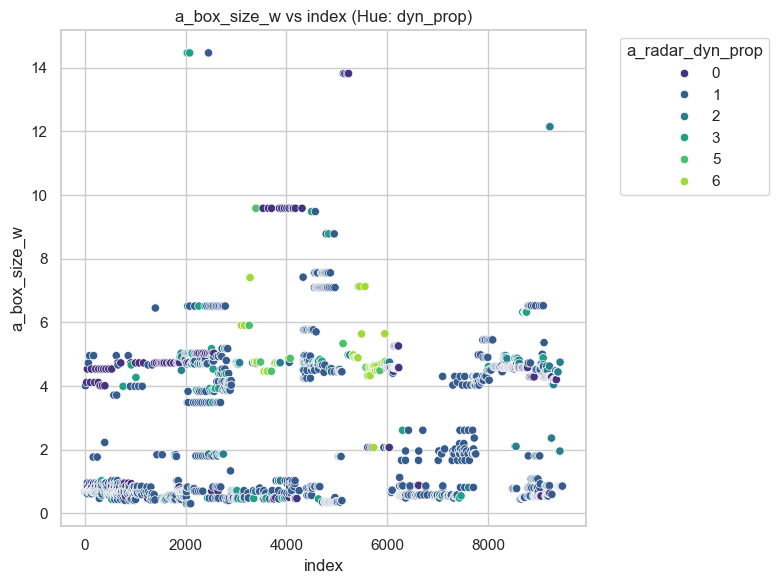

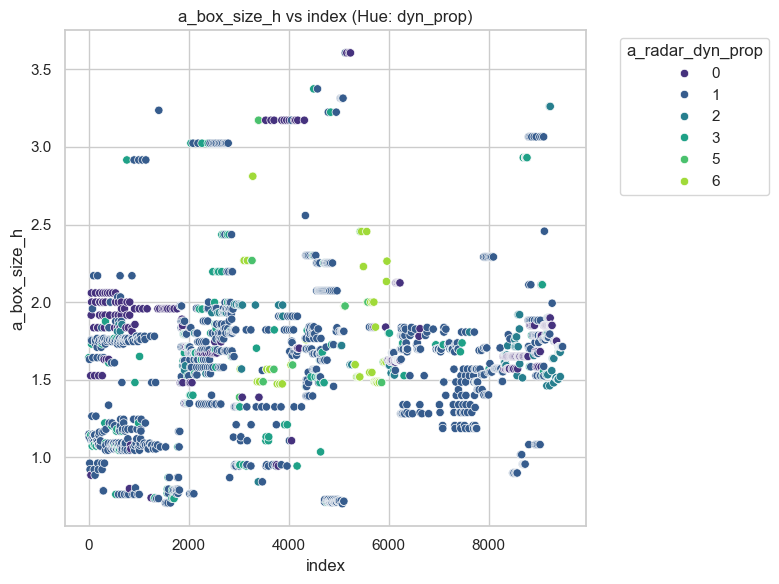

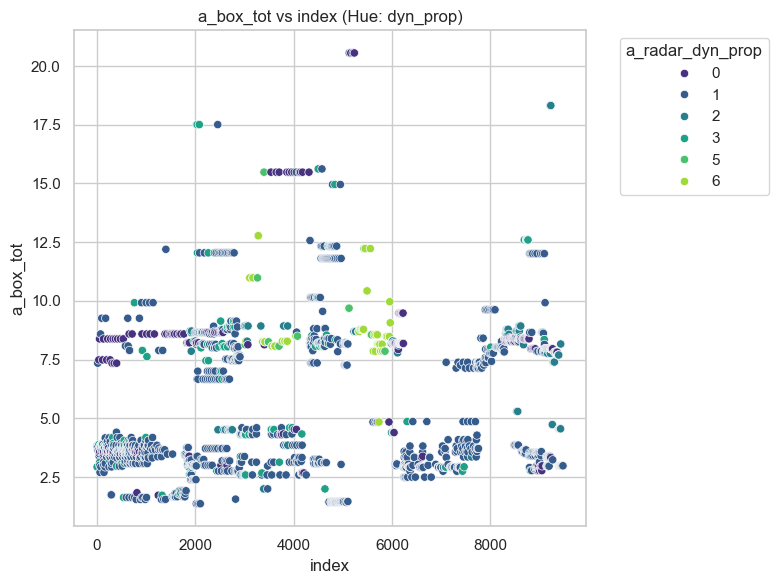

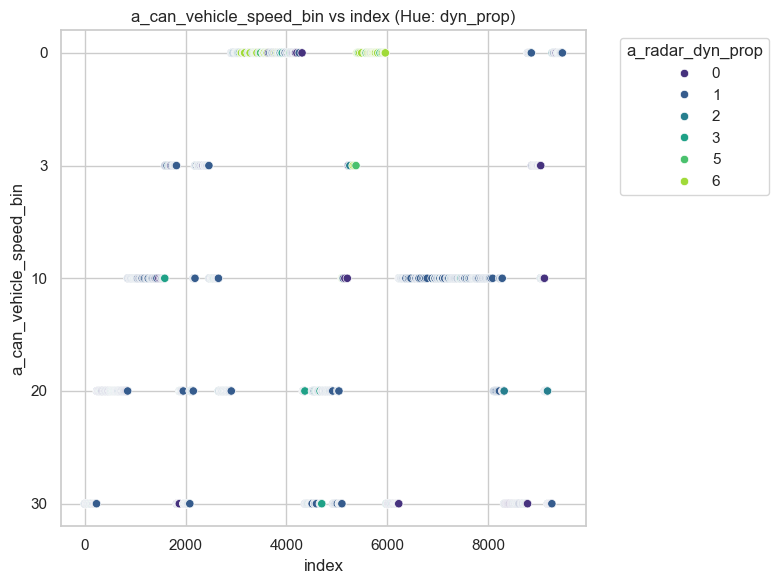

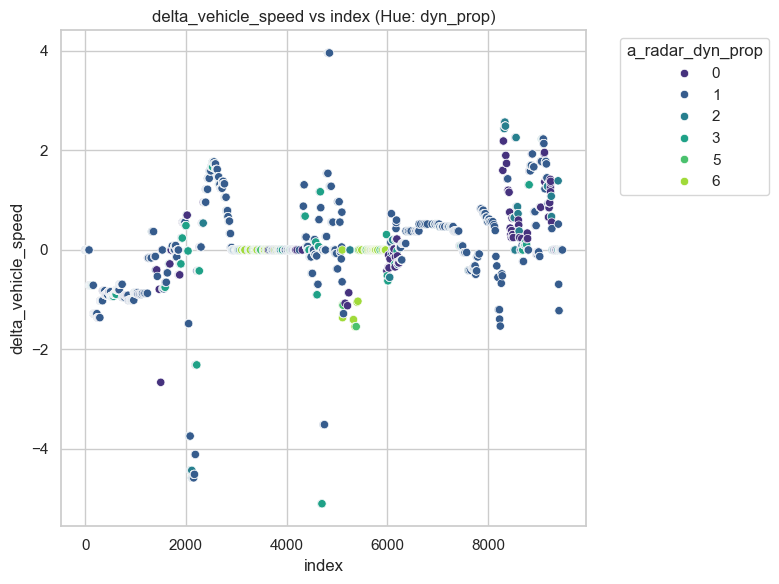

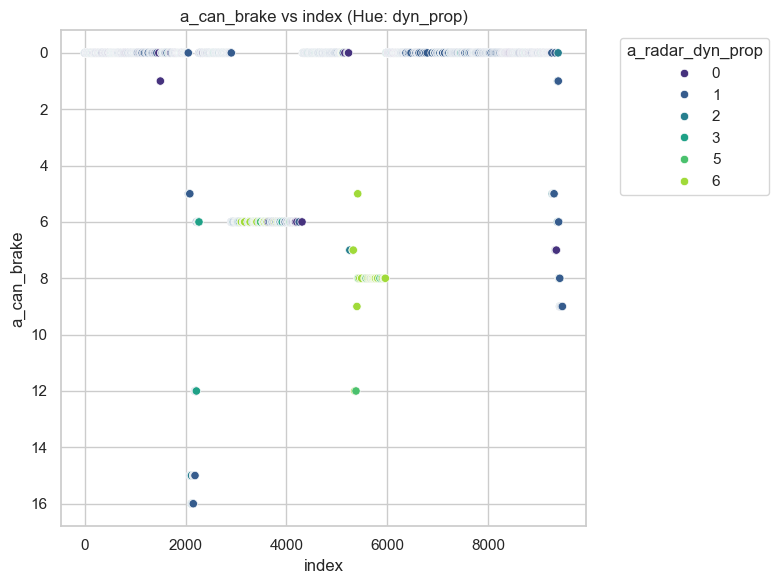

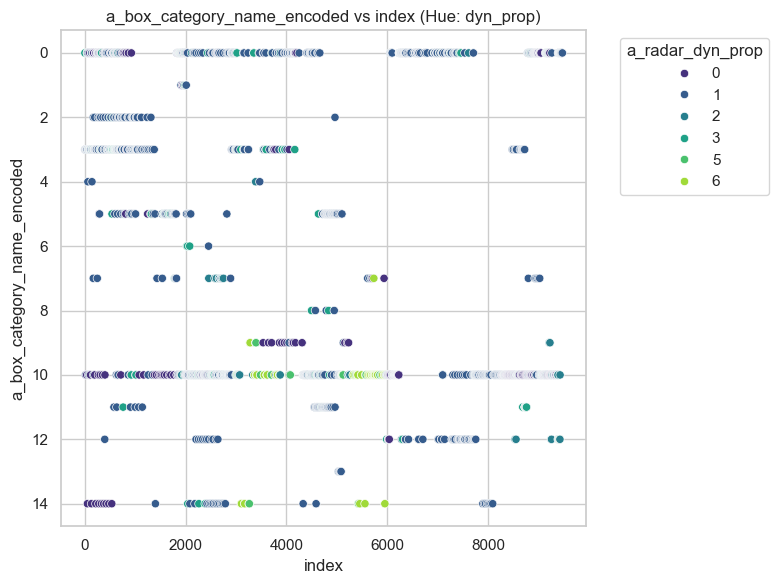

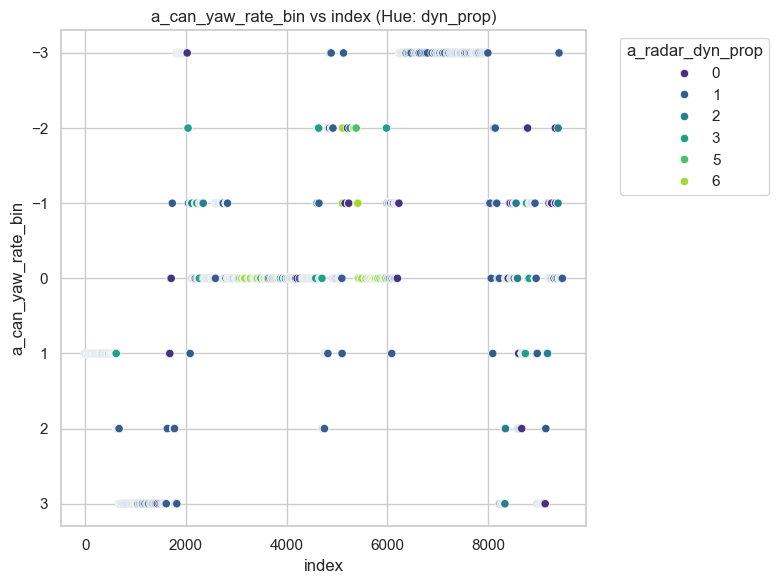

In [22]:
plot_scatter_by_dyn_prop(df_final_model_data.drop(['b_radar_dyn_prop', 'b_can_yaw_rate_bin', 'b_can_brake'], axis=1), 'a_radar_dyn_prop')